In [165]:
import glob, os
import shutil
import matplotlib.pyplot as plt

import numpy as np
import librosa
from pathlib import Path

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as bk

from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from librosa.feature import melspectrogram
from librosa.display import specshow
'''
'''

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

    
#TODO: export requirements

Num GPUs Available:  1


In [166]:
#Load Dataset
'''
According to esc50 documentation rooster class is = 1.
'''
#50 CLASSES SOUND DATA SET
AUDIO_DS_PATH = Path("Data/Dataset/audio")
DF_PATH =  Path("Data/Dataset/esc50.csv")

#Dataset as pandas dataframe
sdf = pd.read_csv(DF_PATH)

print("Number of entries in Data frame: ", len(sdf.index))
# Count number of rows in a dataframe that contains NaN any column
seriesObj = sdf.apply(lambda x: x.isnull().any(), axis=1)
numOfRows = len(seriesObj[seriesObj == True].index)
print('Number of Rows in dataframe which contain NaN in any column : ', numOfRows)

#PRINT COUNT Fold SETS
seriesObj = sdf.apply(lambda x: True if x['fold'] == 1 else False , axis=1)
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == True].index)
#target classes non categorical indexes easier to work with keras
classes = sorted(sdf.target.unique())

print('Number of folds: ', len(sdf.fold.unique()))
print('Count per fold: ', numOfRows)
print('Classes indexes in non categorical index: ', classes )

#clean data set
# Removed some columsn that don not seem important
sdf = sdf.drop(['take','src_file', 'category','esc10'], axis=1)
sdf.head()

Number of entries in Data frame:  2000
Number of Rows in dataframe which contain NaN in any column :  0
Number of folds:  5
Count per fold:  400
Classes indexes in non categorical index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


,filename,fold,target
0,1-100032-A-0.wav,1,0
1,1-100038-A-14.wav,1,14
2,1-100210-A-36.wav,1,36
3,1-100210-B-36.wav,1,36
4,1-101296-A-19.wav,1,19


In [167]:
#kfold-spliting right now not using fold columns in dataset
kf = KFold(n_splits = 5,shuffle=True, random_state=1)
def get_fold_from(dataframe):
    result = next(kf.split(dataframe), None)
    train = dataframe.iloc[result[0]]
    val =  dataframe.iloc[result[1]]
    return train, val

def get_audiop(audio_fn:str, target):
    return AUDIO_DS_PATH / str(target) / audio_fn

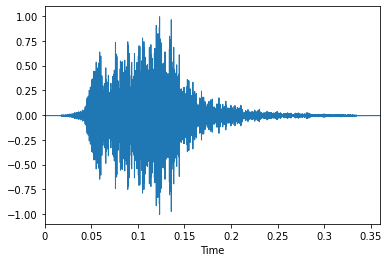

In [168]:
#Compute melspectrogram:
#https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
#import librosa
audio_sample_path  =  AUDIO_DS_PATH /"1-100032-A-0.wav"

def pre_process_stem(audio_path:Path):
    y, sr = librosa.load(audio_path, 44100)
    audio_sample, _  = librosa.effects.trim(y)
    return audio_sample
audio_stem = pre_process_stem(audio_sample_path)
librosa.display.waveplot(audio_sample, sr=sr)


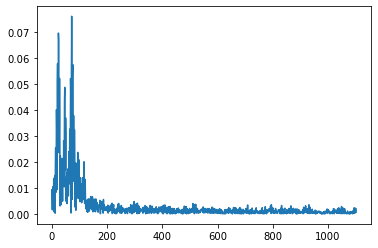

In [169]:
#apply fourier transform
n_fft = 2205 #window size = 50ms

fft_stem = np.abs(librosa.stft(audio_stem[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(fft_stem);

windows shape:  (1103, 36)


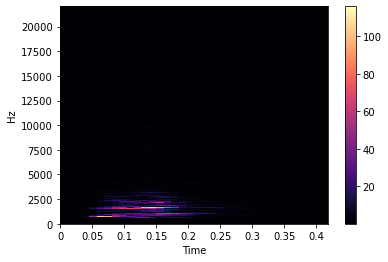

In [170]:
hop_length = 442
def compute_windows(audio_stem):
    windows = np.abs(librosa.stft(audio_stem, n_fft=n_fft,  hop_length=hop_length))
    return windows

windows = compute_windows(audio_stem)
print('windows shape: ', windows.shape)
librosa.display.specshow(windows, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


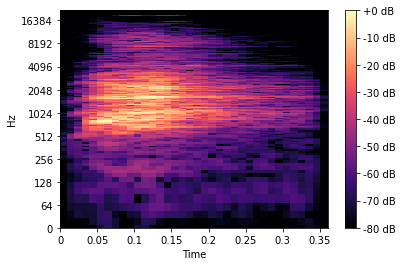

In [171]:
#transform: y-axi (frequency) to log-scale
#color (amplitud) to Decibels
def apply_log_db(windows):
    DB = librosa.amplitude_to_db(windows, ref=np.max)
    return DB
db_scaled_stem = apply_log_db(windows)
librosa.display.specshow(db_scaled_stem, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

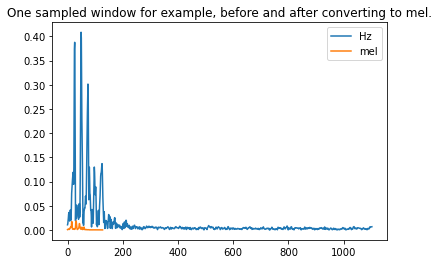

In [172]:
plt.plot(windows[:, 1]);
plt.plot(mel.dot(windows[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');

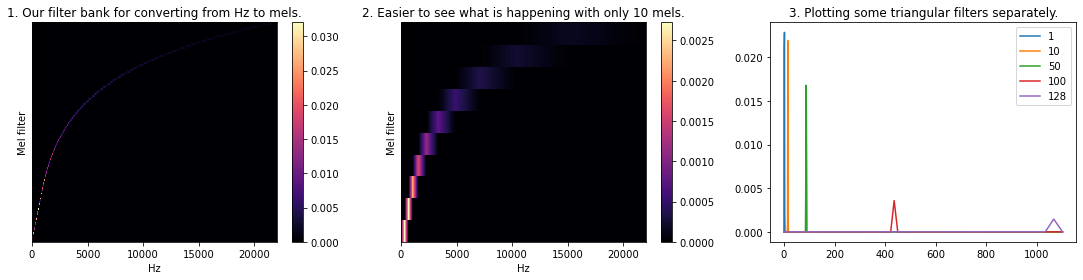

In [173]:
#compute mel spectrogram
n_mels = 128
mel = librosa.filters.mel(sr= 44100, n_fft=n_fft,n_mels=n_mels)

#this patition the Hz scale into bins
#also tranforms each bin into a correpsonding bin in the Mel scale, using
#overlapping triangular filters.

plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\drumm\anaconda3\envs\vhc\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


(128, 36)
(128, 36, 1)


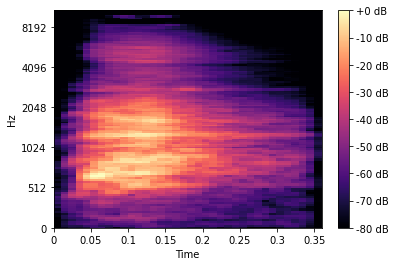

In [174]:
#one liner Mel's Spectrogram

def compute_melspect_for(audio_stem, settings):
    S = librosa.feature.melspectrogram(audio_stem, sr=settings['sr'], n_fft=settings['n_fft'],
                                       hop_length=settings['hop_length'],
                                       n_mels=settings['n_mels'])
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

#n_fft : window size = 50ms must be power of 2 
r_settings= {
    "sr" : 44100,
    "n_fft" : 2205,
    "hop_length" : 441,
    "win_length" : 442,
    "n_mels" : 128,
    "fmin" : 10,
    "fmax" : 22050,
}
    
mels = compute_melspect_for(audio_stem, r_settings)
librosa.display.specshow(mels, sr=r_settings['sr'],
                         hop_length=r_settings['hop_length'],
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

print(S.shape)
reshaped_input = S.reshape(128, 36, 1)
print(reshaped_input.shape)

In [175]:
print(windows[:,1].shape)

(1103,)


In [176]:
#mels will be the input for the network.
def load_audio_windows(audio_path:Path, settings):
    audio_stem = pre_process_stem(audio_path)
    mels = compute_melspect_for(audio_stem, settings)
    return mels

### Define Model

In [177]:
'''
frames=settings["frames"],
bands=settings["n_mels"],
channels=settings.get("channels", 1),
'''    
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2

def build_model(frames=36, bands=128, channels=1, num_labels=10,
                conv_size=(5,5), conv_block='conv',
                downsample_size=(4,2),
                fully_connected=64,
                n_stages=None, n_blocks_per_stage=None,
                filters=24, kernels_growth=2,
                dropout=0.5,
                use_strides=False):
    """
    Implements SB-CNN model from
    Deep Convolutional Neural Networks and Data Augmentation for Environmental Sound Classification
    Salamon and Bello, 2016.
    https://arxiv.org/pdf/1608.04363.pdf
    Based on https://gist.github.com/jaron/5b17c9f37f351780744aefc74f93d3ae
    but parameters are changed back to those of the original paper authors,
    and added Batch Normalization
    """
    Conv2 = SeparableConv2D if conv_block == 'depthwise_separable' else Convolution2D
    assert conv_block in ('conv', 'depthwise_separable')
    kernel = conv_size
    if use_strides:
        strides = downsample_size
        pool = (1, 1)
    else:
        strides = (1, 1)
        pool = downsample_size

    block1 = [
        Convolution2D(filters, kernel, padding='same', strides=strides,
                      input_shape=(bands, frames, channels)),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool),
        Activation('relu'),
    ]
    block2 = [
        Conv2(filters*kernels_growth, kernel, padding='same', strides=strides),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool),
        Activation('relu'),
    ]
    block3 = [
        Conv2(filters*kernels_growth, kernel, padding='valid', strides=strides),
        BatchNormalization(),
        Activation('relu'),
    ]
    backend = [
        Flatten(),

        Dropout(dropout),
        Dense(fully_connected, kernel_regularizer=l2(0.001)),
        Activation('relu'),

        Dropout(dropout),
        Dense(num_labels, kernel_regularizer=l2(0.001)),
        Activation('softmax'),
    ]
    layers = block1 + block2 + block3 + backend
    model = Sequential(layers)
    return model

In [178]:
def dataframe_generator(data,audio_settings, batchsize=10):
    """
    Keras generator for lazy-loading data based on a pandas.DataFrame
    """
    idx = np.random.choice(len(data), size=batchsize, replace=False)
    rows = data.iloc[idx, :].iterrows()
    audio_paths = [get_audiop(row.filename, row.target) for _, row in rows]        
    mels = [load_audio_windows(p,audio_settings) for p in audio_paths]
    targets = [row.target for _, row in rows]
    batch = (np.array(mels), np.array(targets))
    yield batch
        

In [181]:
MODEL_DIR = Path("models")

model_settings = {
    "samplerate": 44100,
    "n_mels": 128,
    "fmin": 10,
    "fmax": 22050,
    "n_fft": 2205,
    "hop_length": 441,
    "frames": 36,
    "batch": 10,
    "epochs": 100,
    "learning_rate": 0.005,
    "nesterov_momentum": 0.9,
}

r_settings= {
    "sr" : 44100,
    "n_fft" : 2205,
    "hop_length" : 441,
    "win_length" : 442,
    "n_mels" : 128,
    "fmin" : 10,
    "fmax" : 22050,
}

def check_model_dir(model_p = Path):
    if model_p.is_dir():
        print('models directory exists')
    else:
        model_p.mkdir(exist_ok=True)
    return model_p

def train_model(out_dir, train, val, model, settings):
    frame_samples = settings['hop_length']
    window_frames = settings['frames']
    epochs = settings['epochs']
    batch_size = settings['batch']
    lr = settings['learning_rate']
    momentum = settings['nesterov_momentum']
    
    
    optimizer = keras.optimizer.SGD(lr=lr, momentum=momentum, nesterov=True)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracu"])
    
    model_path = out_dir / "e{epoch:02d}-v{val_loss:.2f}.t{loss:.2f}.model.hdf5"
    
    checkpoint = bk.callbacks.ModelCheckpoint(
        model_path,
        monitor="val_acc",
        mode="max",
        period=1,
        verbose=1,
        save_best_only=False,
    )
    
    
    train_gen = dataframe_generator(train, batchsize=batch_size)
    val_gen = dataframe_generator(val, batchsize=batch_size)
    
    hist = model.fit_generator(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=math.ceil(len(train) / batch_size),
        validation_steps=math.ceil(len(val) / batch_size),
        callbacks=callbacks_list,
        epochs=epochs,
        verbose=1,
    )
    df = history_dataframe(hist)
    history_path = os.path.join(out_dir, "history.csv")
    df.to_csv(history_path)
    
    return hist
    
def history_dataframe(h):
    data = {}
    data["epoch"] = h.epoch
    for k, v in h.history.items():
        data[k] = v
    df = pandas.DataFrame(data)
    return df

def predict_model(settings, model, samples, loader, method="mean", overlap=0.5):

    out = []
    for _, sample in samples.iterrows():
        windows = load_windows(sample, settings, loader, overlap=overlap)
        inputs = numpy.stack(windows)

        predictions = model.predict(inputs)
        if method == "mean":
            p = numpy.mean(predictions, axis=0)
            assert len(p) == 10
            out.append(p)
        elif method == "majority":
            votes = numpy.argmax(predictions, axis=1)
            p = numpy.bincount(votes, minlength=10) / len(votes)
            out.append(p)

    ret = numpy.stack(out)
    assert len(ret.shape) == 2, ret.shape
    assert ret.shape[0] == len(out), ret.shape
    assert ret.shape[1] == 10, ret.shape  # classes

    return ret

def main():
    name = "vh_challenge"
    output_dir= check_model_dir(MODEL_DIR)
    #Check data exists
    
    for f in range(5):
        train_data,  val_data = get_fold_from(sdf)
        
        m = build_model()
        m.summary()
        print("Training model", name)
        
        t= train_model(output_dir, train_data, val_data, m, model_settings)
        
        

In [182]:
main()

models directory exists
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 36, 24)       624       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 36, 24)       96        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 18, 24)        0         
_________________________________________________________________
activation_11 (Activation)   (None, 32, 18, 24)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 18, 48)        28848     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 18, 48)        192       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (

AttributeError: module 'tensorflow_core.keras' has no attribute 'optimizer'